In [72]:
import numpy as np
import pandas as pd
import xarray as xr
from datetime import date

import regionmask

import matplotlib.pyplot as plt

import cartopy.crs as ccrs
import cartopy.feature as cfeature
import cartopy.mpl.ticker as cticker
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER
import cartopy.io.shapereader as shpreader

In [69]:
#obs
f=xr.open_dataset("/Users/dongxiay/Documents/data/ratio.nc")
ratio=f['apcp']

In [57]:
#Monte resamples
fmonte=xr.open_dataset("/Users/dongxiay/Documents/data/ratiom.nc")
ds=fmonte.rename_dims({'phase_50': 'phase'})
ds

<xarray.Dataset>
Dimensions:   (lat: 46, lon: 61, phase: 9, iteration: 1709)
Coordinates:
  * lat       (lat) float32 -45.0 -44.0 -43.0 -42.0 -41.0 ... -3.0 -2.0 -1.0 0.0
  * lon       (lon) float32 100.0 101.0 102.0 103.0 ... 157.0 158.0 159.0 160.0
    quantile  float64 ...
    phase_50  (phase) float64 0.0 1.0 2.0 3.0 4.0 5.0 6.0 7.0 8.0
Dimensions without coordinates: phase, iteration
Data variables:
    apcp      (iteration, phase, lat, lon) float64 ...

In [58]:
#ranking based on the iteration dimension for each phase/lat/lon
a=ds['apcp'].sortby(ds['iteration'])

In [96]:
#calculate the p-value, if obs is outside of p1/p2, then mask=1 (or true)
p1=a.quantile(0.1,dim="iteration")
p2=a.quantile(0.9,dim="iteration")

In [101]:
sig= xr.where((f["apcp"] >= p2) | (f["apcp"] <= p1), 1, -1)

In [103]:
import regionmask
mask = regionmask.defined_regions.natural_earth.countries_110.mask(ratio)
AU_index = regionmask.defined_regions.natural_earth.countries_110.map_keys('AU')
ratio_AU = ratio.where(mask == AU_index)
sig_AU = sig.where(mask == AU_index)

In [75]:
# import NCL colormap
! pip install cmaps
import cmaps

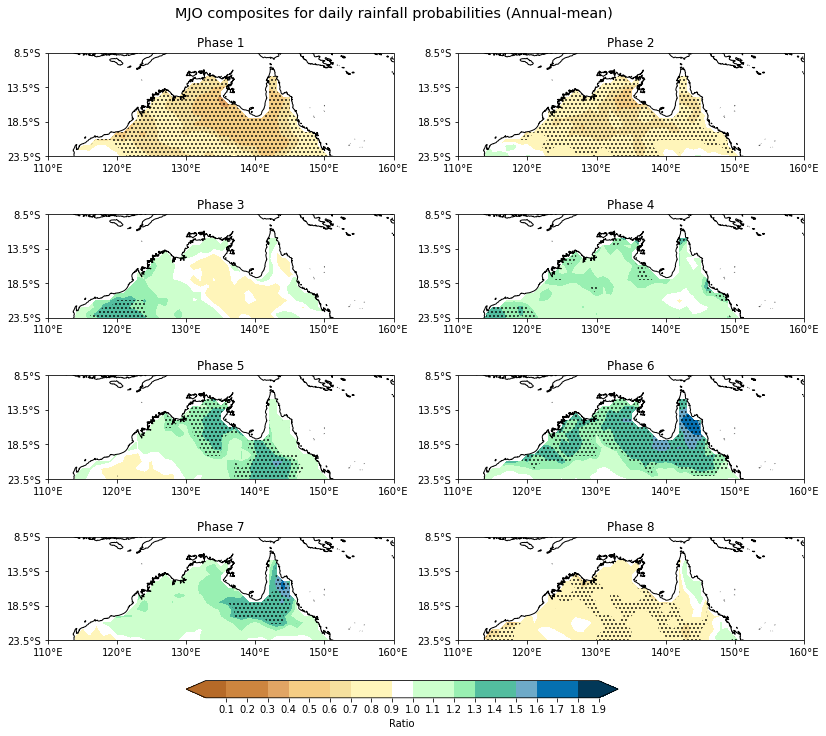

In [128]:
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature 
import cartopy.mpl.ticker as cticker 


leftlon, rightlon, lowerlat, upperlat = (110,160,-23.5,-10)
img_extent = [leftlon, rightlon, lowerlat, upperlat]
lon_formatter = cticker.LongitudeFormatter()
lat_formatter = cticker.LatitudeFormatter()

title=[]
for i in range(1,9,1):
    title.append(f'Phase {i}')
   
fig = plt.figure(figsize=(12,8))

for i in range(4):
    for j in range(2):
        ax = fig.add_axes([0.1+j*0.475, 1.5-i*0.28, 0.4, 0.3],projection = ccrs.PlateCarree())
#         ax.set_title('({})'.format(title[i,j]),loc='left',fontsize=14)
        ax.set_extent(img_extent, crs=ccrs.PlateCarree())
        ax.add_feature(cfeature.COASTLINE) 
        ax.set_xticks(np.arange(leftlon,rightlon+10,10), crs=ccrs.PlateCarree())
        ax.set_yticks(np.arange(lowerlat,upperlat+5,5), crs=ccrs.PlateCarree())
        ax.xaxis.set_major_formatter(lon_formatter)
        ax.yaxis.set_major_formatter(lat_formatter)
        ax.title.set_text(title[i*2+j])
        c = ax.contourf(ratio['lon'],ratio['lat'],ratio_AU[i*2+j+1,:,:],
                        levels=np.arange(0,2,0.1),
                        extend='both' ,
                        cmap=cmaps.precip_diff_12lev,
                        transform=ccrs.PlateCarree()) 
        #绘制显著性打点。思路为将0-0.05范围内的区域用点的标记来填充，来表示显著性95%水平。
        cf2 =ax.contourf(ratio['lon'],ratio['lat'],sig_AU[i*2+j+1,:,:],[0.9,1],
                         zorder=1,hatches=['...', None],
                         colors="none", 
                         transform=ccrs.PlateCarree())
        
#colorbar, You would want to make sure the colorbar always sits in the same axes. 
# To this end, you may create a colorbar axes (cax) outside the loop
fig.colorbar(c, cax=fig.add_axes([0.26, 0.62, 0.5, 0.03 ]),
             orientation='horizontal',  
             label= 'Ratio', 
             ticks=np.arange(0.1,2.1,0.1),
             shrink=0.7)
st=fig.suptitle("MJO composites for daily rainfall probabilities (Annual-mean)",fontsize="x-large")
st.set_y(1.82)
fig.subplots_adjust(top=1.5)

plt.savefig("MJOcomp_daily_rain_prob_ANN.pdf", format="pdf",bbox_inches = 'tight')

In [ ]:
### mask ocean   
# fmask=xr.open_dataset("/Users/dongxiay/Documents/data/daily/land.nc")
# mask = fmask['land'].loc['1836-01-01',-45:0,100:160]
# ds_l = ds.where(mask)